In [1]:
from fastai.vision.all import *
from fastai.callback.wandb import WandbCallback
import wandb

from self_supervised.augmentations import *
from self_supervised.layers import *
from self_supervised.vision.swav import *

## Pretraining

In [2]:
sqrmom=0.99
mom=0.95
beta=0.
eps=1e-4
opt_func = partial(ranger, mom=mom, sqr_mom=sqrmom, eps=eps, beta=beta)

In [3]:
def get_dls(size, bs, workers=None):
    path = URLs.IMAGEWANG_160 if size <= 160 else URLs.IMAGEWANG
    source = untar_data(path)
    
    files = get_image_files(source)
    tfms = [[PILImage.create, ToTensor, RandomResizedCrop(size, min_scale=1.)], 
            [parent_label, Categorize()]]
    
    dsets = Datasets(files, tfms=tfms, splits=RandomSplitter(valid_pct=0.1)(files))
    
    batch_tfms = [IntToFloatTensor]
    dls = dsets.dataloaders(bs=bs, num_workers=workers, after_batch=batch_tfms)
    return dls

In [4]:
bs=96
resize, size = 256, 224
K = bs*2**4

In [5]:
arch = "xresnet34"
encoder = create_encoder(arch, pretrained=False, n_in=3)

In [6]:
xtra_config = {"Arch":arch, "Resize":resize, "Size":size, "Algorithm":"SWAV"}
wandb.init(project="self-supervised-imagewang", config=xtra_config);

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Currently logged in as: keremturgutlu (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.21 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [7]:
dls = get_dls(resize, bs)
model = create_swav_model(encoder, n_in=3)
learn = Learner(dls, model,
                cbs=[SWAV(aug_func=get_batch_augs,
                          K=K,
                          queue_start_pct=0.5,
                          crop_sizes=[size,int(3/4*size)], #4/3 - large to small crop size ratio is an important hyperparam for optimization! If we kept small crop 96 and just increased 128 to 192 training has hard time
                          num_crops=[2,6],
                          min_scales=[0.25,0.2],
                          max_scales=[1.0,0.35],                
                          rotate=True,
                          rotate_deg=10,
                          jitter=True,
                          bw=True,
                          blur=False
                          ),
                     TerminateOnNaNCallback(),
                     WandbCallback(log_preds=False,log_model=False)
                     ])

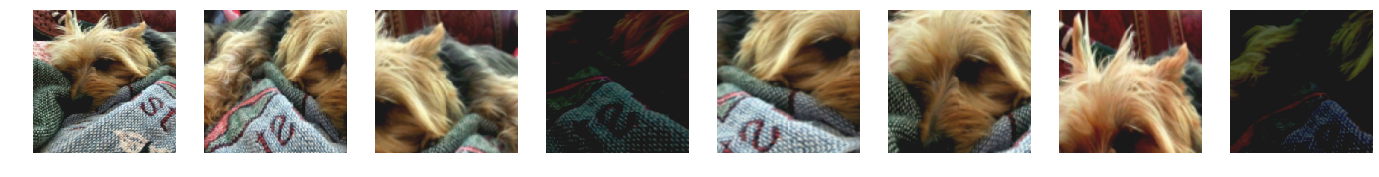

In [8]:
b = dls.one_batch()
learn._split(b)
learn('before_batch')
learn.swav.show_one()

In [8]:
learn.to_fp16();

In [9]:
lr=1e-2
wd=1e-2
epochs=100

In [10]:
learn.unfreeze()
learn.fit_flat_cos(epochs, lr, wd=wd, pct_start=0.5)

epoch,train_loss,valid_loss,time
0,7.407468,7.684866,02:58
1,7.030927,7.189878,02:52
2,6.837667,6.869849,02:52
3,6.633281,7.156127,02:52
4,6.468298,6.766192,02:54
5,6.345496,6.350045,02:53
6,6.241495,6.387009,02:54
7,6.162815,6.393086,02:53
8,6.081127,6.323627,02:53
9,5.999241,6.243154,02:51


In [11]:
wandb.finish()

epoch,100
train_loss,3.44818
raw_loss,3.29779
wd_0,0.01
sqr_mom_0,0.99
lr_0,0.0
mom_0,0.9
eps_0,1e-05
_runtime,17580
_timestamp,1615028411
_step,24699


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▇▆▆▅▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄▅▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
raw_loss,█▇▇▆▅▆▅▆▅▅▅▅▅▄▅▄▅▄▄▄▅▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▁▁▂▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,███████████████████████▇▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁
mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


In [12]:
save_name = f'swav_iwang_sz{size}_epc{epochs}'
learn.save(save_name)
torch.save(learn.model.encoder.state_dict(), learn.path/learn.model_dir/f'{save_name}_encoder.pth')

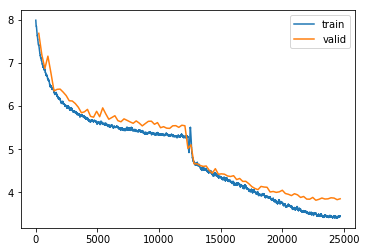

In [13]:
learn.recorder.plot_loss()

## Downstream Task

In [14]:
bs, size

(96, 224)

In [15]:
def get_dls(size, bs, workers=None):
    path = URLs.IMAGEWANG_160 if size <= 160 else URLs.IMAGEWANG
    source = untar_data(path)
    files = get_image_files(source, folders=['train', 'val'])
    splits = GrandparentSplitter(valid_name='val')(files)
    
    item_aug = [RandomResizedCrop(size, min_scale=0.35), FlipItem(0.5)]
    tfms = [[PILImage.create, ToTensor, *item_aug], 
            [parent_label, Categorize()]]
    
    dsets = Datasets(files, tfms=tfms, splits=splits)
    
    batch_tfms = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)]
    dls = dsets.dataloaders(bs=bs, num_workers=workers, after_batch=batch_tfms)
    return dls

In [16]:
def split_func(m): return L(m[0], m[1]).map(params)

def create_learner(size=size, arch='xresnet34', encoder_path="models/swav_iwang_sz128_epc100_encoder.pth"):
    
    dls = get_dls(size, bs=bs//2)
    pretrained_encoder = torch.load(encoder_path)
    encoder = create_encoder(arch, pretrained=False, n_in=3)
    encoder.load_state_dict(pretrained_encoder)
    nf = encoder(torch.randn(2,3,224,224)).size(-1)
    classifier = create_cls_module(nf, dls.c)
    model = nn.Sequential(encoder, classifier)
    learn = Learner(dls, model, opt_func=opt_func, splitter=split_func,
                metrics=[accuracy,top_k_accuracy], loss_func=LabelSmoothingCrossEntropy())
    return learn

In [17]:
def finetune(size, epochs, arch, encoder_path, lr=1e-2, wd=1e-2):
    learn = create_learner(size, arch, encoder_path)
    learn.unfreeze()
    learn.fit_flat_cos(epochs, lr, wd=wd)
    final_acc = learn.recorder.values[-1][-2]
    return final_acc

### 5 epochs

In [18]:
acc = []
runs = 5
for i in range(runs): acc += [finetune(size, epochs=5, arch='xresnet34', encoder_path=f'models/swav_iwang_sz{size}_epc100_encoder.pth')]

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.983487,1.558032,0.711631,0.921354,00:58
1,0.907253,1.474977,0.730211,0.930517,00:58
2,0.878498,1.430007,0.734284,0.932298,01:00
3,0.826681,1.326239,0.759990,0.948333,00:58
4,0.735671,1.216653,0.794350,0.960295,00:58


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.002475,1.796736,0.648002,0.900229,00:59
1,0.908794,1.402081,0.744719,0.931535,00:58
2,0.858086,1.445738,0.716722,0.933062,00:58
3,0.811090,1.300391,0.776024,0.954441,00:59
4,0.740800,1.217372,0.798167,0.957750,00:58


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.986952,1.708992,0.659964,0.904301,00:59
1,0.937269,1.404593,0.747264,0.942479,00:59
2,0.864935,1.405310,0.750318,0.939425,00:58
3,0.810867,1.288793,0.768389,0.949860,00:58
4,0.742714,1.219064,0.803003,0.958514,00:59


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.968935,1.604818,0.687198,0.940952,00:58
1,0.924613,1.683160,0.633749,0.912955,00:56
2,0.844297,1.621276,0.671418,0.914228,00:55
3,0.825853,1.351661,0.755918,0.949351,00:55
4,0.743408,1.207588,0.789259,0.955968,00:56


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.965100,1.479348,0.741156,0.943752,00:56
1,0.920319,1.532363,0.723085,0.930262,00:55
2,0.845511,1.352898,0.751082,0.940188,00:54
3,0.820847,1.341636,0.766607,0.951642,00:55
4,0.740365,1.209206,0.793332,0.957241,00:53


In [19]:
np.mean(acc)

0.7956223011016845

### 20 epochs

In [20]:
acc = []
runs = 3
for i in range(runs): acc += [finetune(size, epochs=20, arch='xresnet34', encoder_path=f'models/swav_iwang_sz{size}_epc100_encoder.pth')]
np.mean(acc)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.971454,1.545572,0.708323,0.921354,00:54
1,0.927443,1.499802,0.721303,0.939679,00:54
2,0.873696,1.475774,0.729448,0.940443,00:54
3,0.803617,1.430663,0.724103,0.944261,00:54
4,0.803485,1.309435,0.775006,0.945024,00:54
5,0.766212,1.365433,0.744464,0.941715,00:54
6,0.753622,1.369751,0.731738,0.941970,00:54
7,0.743506,1.371420,0.760499,0.940697,00:56
8,0.726871,1.382386,0.747518,0.948587,00:53
9,0.720248,1.393038,0.751082,0.943752,00:54


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.963382,1.713247,0.656656,0.932044,00:56
1,0.931585,1.536007,0.724357,0.937643,00:55
2,0.851089,1.420539,0.756172,0.949606,00:54
3,0.817316,1.328225,0.764062,0.938407,00:54
4,0.793688,1.371521,0.735811,0.932044,00:54
5,0.778133,1.326565,0.766353,0.949351,00:56
6,0.748602,1.449237,0.734029,0.937134,00:55
7,0.751250,1.322996,0.754390,0.945024,00:56
8,0.734199,1.411296,0.729702,0.936880,00:55
9,0.727239,1.264135,0.772970,0.957496,00:56


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.985622,1.549440,0.721812,0.921863,00:56
1,0.917132,1.575578,0.733265,0.920081,00:56
2,0.857101,1.328448,0.764571,0.956986,00:54
3,0.824363,1.346856,0.765589,0.946551,00:54
4,0.794153,1.344439,0.756681,0.948842,00:54
5,0.771290,1.381032,0.756681,0.947569,00:54
6,0.761646,1.365927,0.754645,0.947315,00:54
7,0.734839,1.393742,0.755154,0.936371,00:54
8,0.744643,1.329592,0.759226,0.945788,00:54
9,0.723056,1.427026,0.728430,0.933825,00:54


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### 80 epochs

In [21]:
acc = []
runs = 1
for i in range(runs): acc += [finetune(size, epochs=80, arch='xresnet34',encoder_path=f'models/swav_iwang_sz{size}_epc100_encoder.pth')]
np.mean(acc)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.969396,1.548739,0.710104,0.932553,00:54
1,0.910081,1.519832,0.713668,0.939170,00:55
2,0.853625,1.308844,0.771443,0.944770,00:54
3,0.823330,1.447318,0.729702,0.926190,00:55
4,0.789518,1.322515,0.770171,0.954950,00:54
5,0.774128,1.364938,0.759481,0.939170,00:55
6,0.758874,1.454771,0.720031,0.929244,00:55
7,0.747683,1.323867,0.751082,0.946042,00:54
8,0.731047,1.421696,0.727921,0.933316,00:54
9,0.729223,1.306388,0.767116,0.949096,00:54


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

0.7627894878387451

### 200 epochs

In [ ]:
acc = []
runs = 1
for i in range(runs): acc += [finetune(size, epochs=200, arch='xresnet34', encoder_path=f'models/swav_iwang_sz{size}_epc100_encoder.pth')]
np.mean(acc)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.984085,1.678459,0.670654,0.933825,00:54
1,0.922175,1.501608,0.704759,0.941461,00:54
2,0.854042,1.435633,0.751591,0.942734,00:55
3,0.826787,1.373917,0.754136,0.943497,00:54
4,0.789434,1.392040,0.741919,0.947824,00:54
5,0.776616,1.347452,0.751336,0.944770,00:54
6,0.751912,1.359706,0.756172,0.951387,00:54
7,0.753233,1.408145,0.728175,0.939425,00:55
8,0.747958,1.393444,0.749809,0.944006,00:53
9,0.727515,1.344913,0.763808,0.945533,00:54


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

In [24]:
np.mean(acc)

0.7314838171005249